In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import linprog
from portfolio_optimizer import PortfolioOptimizer

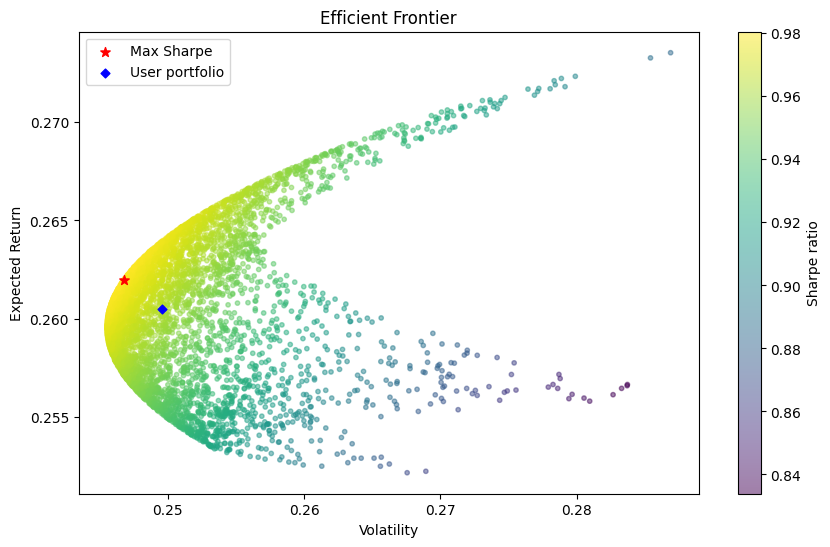

Weights for target return: [0.1        0.62568477 0.        ]
Weights for target vol: [0.2770978  0.39185305 0.05      ]
  Asset    Weight
0  AAPL  0.290029
1  MSFT  0.301309
2  GOOG  0.408662


            Metric  Max Sharpe
0  Expected Return      0.2620
1       Volatility      0.2468
2     Sharpe Ratio      0.9805


In [2]:
# Initialize class
tickers = ['AAPL','MSFT','GOOG']
#tickers = ["IWDA.AS", "VAGF.DE", "IGLN.L"]

opt = PortfolioOptimizer(tickers, start_date='2015-01-01')
opt.fetch_data() ## use when want to fetch US stocks
#opt.fetch_data_eu_etfs() ## use when want to have EU-based ETFs

# Max Sharpe
bounds = [(0.1,0.95), (0.1,0.95), (0,0.05)]
weights, perf = opt.optimize_sharpe()

# Efficient frontier
opt.simulate_efficient_frontier()

# Plot with optional user-selected portfolio
user_weights = [0.5,0.2,0.3]
#user_weights = [0.85, 0.10,0.05]
opt.plot_efficient_frontier(user_weights=user_weights, user_label='User portfolio')

# Target return optimization
target_return = 0.19
weights_ret, perf_ret = opt.optimize_for_return(target_return, bounds)
print("Weights for target return:", weights_ret)

# Target volatility optimization
target_vol = 0.13
weights_vol, perf_vol = opt.optimize_for_volatility(target_vol, bounds)
print("Weights for target vol:", weights_vol)

w_table, perf_table = opt.results_table(weights, label="Max Sharpe")

print(w_table)
print("\n")
print(perf_table)

In [3]:
##
#  CVaR optimization
##
w_cvar, perf_cvar, res = opt.optimize_cvar(alpha=0.95)

w_table, perf_table = opt.results_table(w_cvar, label="CVaR opt")

print(w_table)
print("\n")
print(perf_table)

  Asset    Weight
0  AAPL  0.289628
1  MSFT  0.442593
2  GOOG  0.267779


            Metric  CVaR opt
0  Expected Return    0.2589
1       Volatility    0.2457
2     Sharpe Ratio    0.9724
